# 3

The approach taken here is to numerically integrate the Friedmann equation for the given planck and WMAP models, yielding the scale factor as a function of time.

In [78]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [75]:
import numpy as np
from collections import deque


def adot(a,WL0,Wm0,Wr0):
    # work in hubble time units and assume a0=1
    return np.sqrt(Wm0*(a**(-1.)) + Wr0*(a**(-2.))+WL0*(a**(2.))+ 1.-Wm0-Wr0-WL0 )

def RK4step(x,xd,dt,*args):
    
    k1 = xd(x,*args)
    k2 = xd(x+(0.5*dt*k1),*args)
    k3 = xd(x+(0.5*dt*k2),*args)
    k4 = xd(x+(dt*k3),*args)
    
    return (dt/6.)*(k1+2*(k2+k3)+k4)


def a_RK4(WL0,Wm0,Wr0,H0, dt=1e-6, zi=4200, zf = -.66,zt=None,n=None):
    """
    Simple RK4 integrator for the Friedmann equation. Assumes
    initial conditions of (t,a)=(0,1) and solves for (t,z,a)
    for zi > z > zf.    
    
    dt is a fraction of the hubble time. H0 must be km/s/mpc.
    
    zt is a target redshuft of interest; every iteration
    is saved when z is within 10% of it.
    """
    
    if zt == None:
        zt = 2*zi
        
    if n == None:
        n = 51*dt/1e-6
    
    t = deque([0.])
    a = deque([1.])
    z = deque([0.])
    _a = 1.
    _t = 0.
    _z = 0.
    
    # integrate backwards from a0
    
    i = 0
    while _z < zi:
            
        da = RK4step(_a,adot,-dt,WL0,Wm0,Wr0)     
        
        _a += da
        _t -= dt
        _z = 1./_a -1
        i += 1
        
        if not(i % n):
            a.appendleft(_a)
            t.appendleft(_t)
            z.appendleft(_z)
            
        # save every iteration if we're close to the target redshift   
        elif 0.9*zt < _z < 1.1*zt:
            a.appendleft(_a)
            t.appendleft(_t)
            z.appendleft(_z)
            
    # integrate forward from a0

    _a = 1
    _t = 0
    _z = 0
    
    i = 0
    while  zi > _z > zf:
        
        da = RK4step(_a,adot,dt,WL0,Wm0,Wr0)     
        
        _a += da
        _t += dt
        _z = 1./_a -1
        i += 1
        
        if not(i % n):
            a.append(_a)
            t.append(_t)
            z.append(_z)
            
    # ht is in hubble units, s is in seconds
    z,ht,a = np.array(z),np.array(t),np.array(a)
    s = ht* (3.086e19/(H0)) 
    return s,ht,z,a
    
def diff(t1,a1,t2,a2,n=1000):
    
    ti = max(t1[0],t2[0])
    tf = min(t1[-1],t2[-1])
    
    t = np.linspace(ti,tf,n)
    
    aa1 = np.interp(t,t1,a1)
    aa2 = np.interp(t,t2,a2)
    
    return t,aa1-aa2
    
    

In [76]:
# run the simulations

H0_p = 67. # km/s/mpc
WL0_p = 0.6843
Wm0_p = 0.3157
Wr0_p = 9.2364e-5

t_planck15_s, t_planck15_h0,z_planck15, a_planck15 =  a_RK4(WL0_p,Wm0_p,Wr0_p,H0_p,
                                                            dt = 1e-7, zi = 3700,zt=3400,n=51)

H0_w = 71. # km/s/mpc
WL0_w = 0.734
Wm0_w = 0.266
Wr0_w = 9.2364e-5

t_wmap7_s, t_wmap7_h0,z_wmap7, a_wmap7 =  a_RK4(WL0_w,Wm0_w,Wr0_w,H0_w,
                                                dt = 1e-7, zi = 3700,zt=2900,n=51)


tdiff,adiff = diff(t_planck15_h0, a_planck15,t_wmap7_h0, a_wmap7)
tdiff_s,adiff_s = diff(t_planck15_s, a_planck15,t_wmap7_s, a_wmap7)



KeyboardInterrupt: 

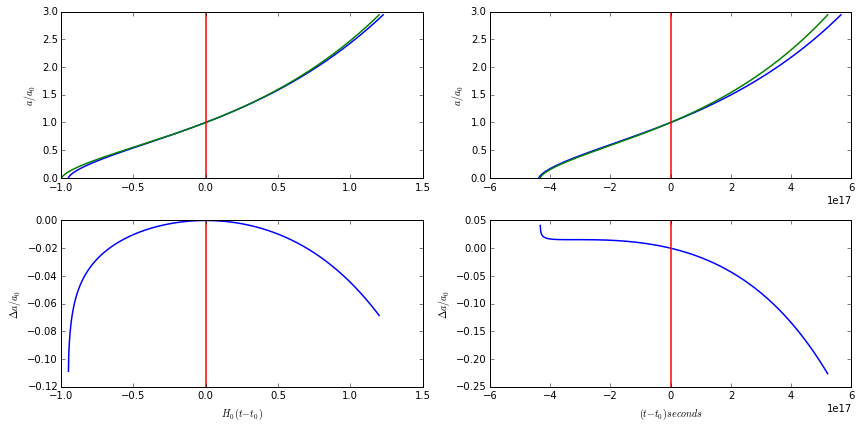

In [79]:
# plot the simulations

fig = plt.figure( figsize=(12,6),dpi=240 )

ax1 = fig.add_subplot(221)
ax1.plot(t_planck15_h0, a_planck15,linewidth=1.5)
ax1.plot(t_wmap7_h0, a_wmap7,linewidth=1.5)
ax1.axvline(x=0,linewidth=1.5,color='r')

ax1.set_ylabel('$a/a_0$')

ax2 = fig.add_subplot(223,sharex=ax1)
ax2.plot(tdiff,adiff,linewidth=1.5)
ax2.axvline(x=0,linewidth=1.5,color='r')
ax2.set_ylabel('$\Delta a/a_0$')

ax2.set_xlabel('$H_0(t-t_0)$')


ax3 = fig.add_subplot(222)
ax3.plot(t_planck15_s, a_planck15,linewidth=1.5)
ax3.plot(t_wmap7_s, a_wmap7,linewidth=1.5)
ax3.axvline(x=0,linewidth=1.5,color='r')
ax3.set_ylabel('$a/a_0$')

ax4 = fig.add_subplot(224,sharex=ax3)
ax4.plot(tdiff_s,adiff_s,linewidth=1.5)
ax4.axvline(x=0,linewidth=1.5,color='r')
ax4.set_ylabel('$\Delta a/a_0$')

ax4.set_xlabel('$(t-t_0)seconds$')

fig.tight_layout()

fig.show()


Above: Expansion history of WMAP7 and Planck2015 models, both assuming a $\Omega_r \approx 9 \times 10^{-5}$. Planck is in blue, WMAP is in green. The lower row is the residual $(a_{planck} - a_{WMAP})/a_0$.

$\\$

$\Omega_r =\Omega_{r,0}(1+z)^4 $ and $\Omega_m = \Omega_{m,0}(1+z)^3$ are equal when $z = z_{eq}=\Omega_{m,0}/\Omega_{r,0} - 1$ For Planck 2015, $z_{eq}=3417$ and for WMAP7, $z_{eq}=2879$. Zooming in on plots of $z$ vs $(t-t_0)_{eq}$ for our simulation runs, we find   $(t-t_0)_{eq} \approx -4.38 \times 10^{17} \,\mathrm{s}$ for Planck 2015 and $(t-t_0)_{eq} \approx -4.33 \times 10^{17} \mathrm{s}\,$ for WMAP7.


#4

$\rho_m$ dilutes as $a^{-3}$ while $\rho_{\Lambda}$ is constant. Therefore, we have matter-dark energy equality at

$$ a_{eq} = \left( \frac{\Omega_{m,0}}{\Omega_{\Lambda,0}}\right)^{1/3}$$

For the Planck 2015 values, $a_{eq} = 0.773$ Looking at the expansion history above, this happens at $ t-t_0 \approx -1.3 \times 10^{17}\, \mathrm{s}$. Again inspecting the plots above, the Planck 2015 universe looks to have $t_0$ at about $4.38\times 10^{17}\, \mathrm{s} $, so we could say $t_{eq}\approx 3.08\times 10^{17}\, \mathrm{s}$, or about 9.767 billion years.

# 5

The Friedmann model for for a flat, radiation-dominated universe is

$$ \dot{a} = H_0a_0\sqrt{\Omega_{r,0}(a/a_0)^{-2}}$$

It's easy to see that a solution of the form $\beta t^{1/2}$ is valid:

$$ \frac{d}{dt}\beta t^{1/2} = \frac{1}{2}\beta t^{-1/2} = H_0a_0^2\sqrt{\Omega_{r,0}}\beta^{-1}t^{-1/2} $$

So $\beta = \sqrt{2H_0a_0^2\sqrt{\Omega_{r,0}}}$. Radiation energy density goes with $a^{-4}$, and also with $T^4$:

$$ \begin{align*}
    \rho_r = \rho_{r,0}a^{-4} &= \frac{4\sigma}{c}T^4 \\[11pt]
    \implies T &= \left(\frac{\rho_{r,0}c}{4\sigma}\right)^{1/4}a^{-1} =  \left(\frac{\rho_{r,0}c}{4\sigma}\right)^{1/4}\beta^{-1}t^{-1/2} \\[11pt]
    &\equiv At^{-1/2}
\end{align*}$$

I'll try to evaluate A in SI units, using

$$\begin{align*}
H_0 &= 67.8 \mathrm{km/s/Mpc} = 2.2 \times 10^{-18} \mathrm{s^{-1}} \\
\rho_{r,0} &= 7.86 \times 10^{-31} \mathrm{Kg\,m^{-3}} = 7.07 \times 10^{-14}\,\mathrm{J\,m^{-3}} \\
\Omega_{r,0} &= 9.24 \times 10^{-5}
\end{align*}$$

which gives A = $1.51 \times 10^{10} \,\mathrm{K\,}\sqrt{\mathrm{s}}$

## 6

I'll interpret the problem statement to mean that we are to assume nucleosynthesis started when the scale factor was $(3 \times 10^{-9})a_0 $. This corresponds to a redshift $z_n = 3.3 \times 10^{8}$, which is long before the start of the matter epoch, so the radiation dominated approximation should work. Then assuming $a=\beta t^{1/2}$ gives $t_n = (a_n/\beta)^2 = 212\, $ seconds.

##9

We know in advance that last scattering ($t \approx 380,000\, \mathrm{years}$) happened long after a relatively brief radiation epoch (ending at $t \approx 50,000\, \mathrm{years}$) and long before the dark energy epoch (starting at $t \approx 10^9\,\mathrm{years}$), so let's assume that we have a totally matter dominated, $\Omega_m = 1$ universe at all (relevant) times.

The scale factor is easily found exactly in this scenario:

$$ \begin{align*}
\dot{a} &= a_0H_0\sqrt{(\Omega_m a^{-1})} = H_0a^{-1/2}
\end{align*}$$

Attempting a solution $a=\beta t^k$,

$$\begin{align*}
\dot{a} &= k\beta t^{k-1} = H_0\beta^{-1/2}t^{-k/2} \\[11pt]
&\implies k-1 = -k/2 \implies k=2/3 \\[11pt]
&\implies \beta = \left(\frac{3}{2}H_0\right)^{2/3}
\end{align*}$$

So $a=\left(\frac{3}{2}H_0t\right)^{2/3}$. Let $a^*$ be the scale factor at the surface of last scattering. The time at last scattering will be $t^* = \frac{2}{3H_0}a^*\,^{3/2}$, with a particle horizon of

$$d_h = a^* \int_0^{t^*} \frac{dt}{a} = \frac{2}{H_0}a^*\,^{3/2} $$

The last piece we need is the angular diameter distance to the surface of last scattering. For a spatially flat universe, this is

$$ d_A = (1+z^*)^{-1}\int_{t*}^{0}\frac{c\mathrm{dt}}{a}$$

though for this calculation we can't assume a matter dominated universe, since we're integrating over both matter and vacuum dominated times. Fortunately, we already have numerical values for $a$ during this period. Assuming $z^* = 1100$, 

In [55]:
# find the angular diameter distance

Z = 1100.
A = 1/(1+Z)
c = 3e8

H0 = H0_p/3.086e19 # need hubble constant in units of inverse seconds

i = np.logical_and(z_planck15<Z,z_planck15>0)
a = a_planck15[i][:-1]
dt = np.diff(t_planck15_s[i])

d_a=A*np.sum(dt/a)

# find the horizon distance on the surface of last scattering
d_h = (A**(1.5))*(2/H0)

theta = (d_h/d_a) * (360/(2*np.pi)) # degrees
d_h = c*d_h / 3.086e19 # kiloparsecs



We finally end up with a CMB particle horizon of 245.155 Kpc which subtends 1.109 degrees on the sky.